In [1]:
import matplotlib.pyplot as plt
import numpy as np
import OOPAO
import tomoAO




     °          *      *      
 ▄██▄   ▄██▄  ▄███▄   ▄██▄ * ▄██▄ 
██* ██ ██  ██ ██  ██ ██  ██ ██  ██
██  ██ ██° ██ ██  ██ ██* ██ ██  ██
██  ██ ██  ██ ████▀  ██▄▄██ ██  ██
██* ██ ██  ██ ██     ██▀▀██ ██  ██
██  ██ ██  ██ ██ *   ██  ██ ██* ██
 ▀██▀   ▀██▀  ██   ° ██  ██  ▀██▀ 
      *         *             




In [2]:
config_dir = "./"
config_file = "config.ini"

ao_mode = "MLAO"

config_vars = tomoAO.IO.load_from_ini(config_file, ao_mode=ao_mode,config_dir=config_dir)

## Asterism Object

By default, the OPD for each source is initialized as a zero array with shape (100, 100). This leads to issues when the initial propagation does not involve the atmosphere. A solution for this case still needs to be determined.

In [3]:
from OOPAO.Source import Source
from OOPAO.Asterism import Asterism

optBand = config_vars["lgs_opticalBand"]
magnitude = config_vars["lgs_magnitude"]
lgs_zenith = config_vars["lgs_zenith"]
lgs_azimuth = config_vars["lgs_azimuth"]
lgs_altitude = config_vars["lgs_altitude"]

n_lgs = config_vars["n_lgs"]

lgsAst = Asterism([Source(optBand=optBand,
              magnitude=magnitude,
              coordinates=[lgs_zenith[kLgs], lgs_azimuth[kLgs]],
            altitude=lgs_altitude)
          for kLgs in range(n_lgs)])


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 5.9e-07 
Zenith [arcsec]          |  10.00  
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  0.00   
Flux [photon/m²/s]       | 9.0e+09 
Coordinates [arcsec,deg] | [10,0]
-----------------------------------


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 5.9e-07 
Zenith [arcsec]          |  10.00  
Azimuth [°]              |  90.00  
Altitude [m]             |   inf   
Magnitude                |  0.00   
Flux [photon/m²/s]       | 9.0e+09 
Coordinates [arcsec,deg] | [10,90]
-----------------------------------


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 5.9e-07 
Zenith [arcsec]          |  10.00  
Azimuth [°]              | 180.00  
Altitude [m]             |   inf   
Magnitude                |  0.00   
Flux [photon/m²/s]       |

In [4]:
lgsAst.print_optical_path()


NGS(Na)
NGS(Na)
NGS(Na)
NGS(Na)


## Telescope Object


------------ Telescope -------------
Diameter [m]             |   8.00   
Resolution [px]          |   160    
Pixel size [m]           |   0.05   
Surface [m²]             |   0.05   
Central obstruction [%]  |    10    
Pixels in pupil          |  19900   
Field of view [arcsec]   |  30.00   
------------------------------------



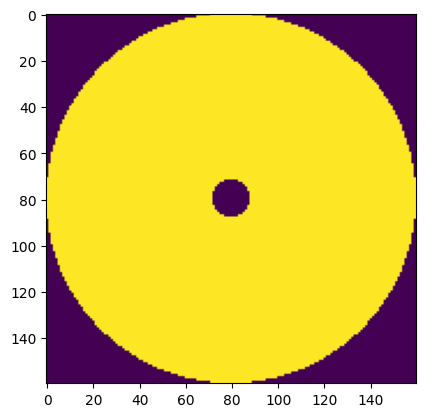

In [5]:
from OOPAO.Telescope import Telescope


sensing_wavelength  = lgsAst.src[0].wavelength           # sensing wavelength of the WFS, read from the ngs object
n_subaperture       = config_vars["nSubaperture"]        # number of subaperture across the diameter
diameter            = config_vars["diameter"]            # diameter of the support of the phase screens in [m]
resolution          = config_vars["resolution"]          # resolution of the phase screens in pixels
obs_ratio           = config_vars["centralObstruction"]  # central obstruction in fraction of the telescope diameter
sampling_time       = config_vars["samplingTime"]        # sampling time of the AO loop in [s]
fieldOfViewInArcsec = config_vars["fieldOfViewInArcsec"] # field of view of the telescope (arcsec)


tel = Telescope(diameter          = diameter,
               resolution         = resolution,
               centralObstruction = obs_ratio,
               samplingTime       = sampling_time,
               fov                = fieldOfViewInArcsec)

plt.imshow(tel.pupil)

## Atmosphere Object

In [6]:
from OOPAO.Atmosphere import Atmosphere

r0 = config_vars["r0"]
L0 = config_vars["L0"]

fractionnalR0 = config_vars["fractionnalR0"]
windSpeed = config_vars["windSpeed"]
windDirection = config_vars["windDirection"]
altitude = config_vars["altitude"]



atm = Atmosphere(telescope      = tel,
                 src            = lgsAst,
                 r0             = r0,
                 L0             = L0,
                 fractionalR0   = fractionnalR0,
                 altitude       = altitude,
                 windDirection  = windDirection,
                 windSpeed      = windSpeed)


atm.initializeAtmosphere(telescope=tel)


Creation of layer1/3 ...
-> Computing the initial phase screen...
initial phase screen : 0.02528095245361328 s
ZZt.. : 6.544248342514038 s
ZXt.. : 0.44207119941711426 s
XXt.. : 0.2669699192047119 s
Done!
Creation of layer2/3 ...
-> Computing the initial phase screen...
initial phase screen : 0.035588741302490234 s
ZZt.. : 5.390141725540161 s
ZXt.. : 0.5386257171630859 s
XXt.. : 0.2510712146759033 s
Done!
Creation of layer3/3 ...
-> Computing the initial phase screen...
initial phase screen : 0.031059741973876953 s
ZZt.. : 2.640889883041382 s
ZXt.. : 0.6211481094360352 s
XXt.. : 0.29274630546569824 s
Done!
Updating the Atmosphere covariance matrices...

------------------------ Atmosphere -------------------------
 Layer | Direction | Speed | Altitude | Frac Cn² | Diameter |
       |    [°]    | [m/s] |   [m]    |   [%]    |   [m]    |
   1   |     0     |  5.0  |  0e+00   |    50    |  8.200   |
   2   |    30     | 15.0  |  5e+03   |    30    |  8.950   |
   3   |    70     | 25.0  | 

For now, the first propagation must pass through the atmosphere.

Since the light has not yet reached the telescope, the OPD does not conform to the pupil shape at this stage.

NGS(Na) ~~> atmosphere
NGS(Na) ~~> atmosphere
NGS(Na) ~~> atmosphere
NGS(Na) ~~> atmosphere


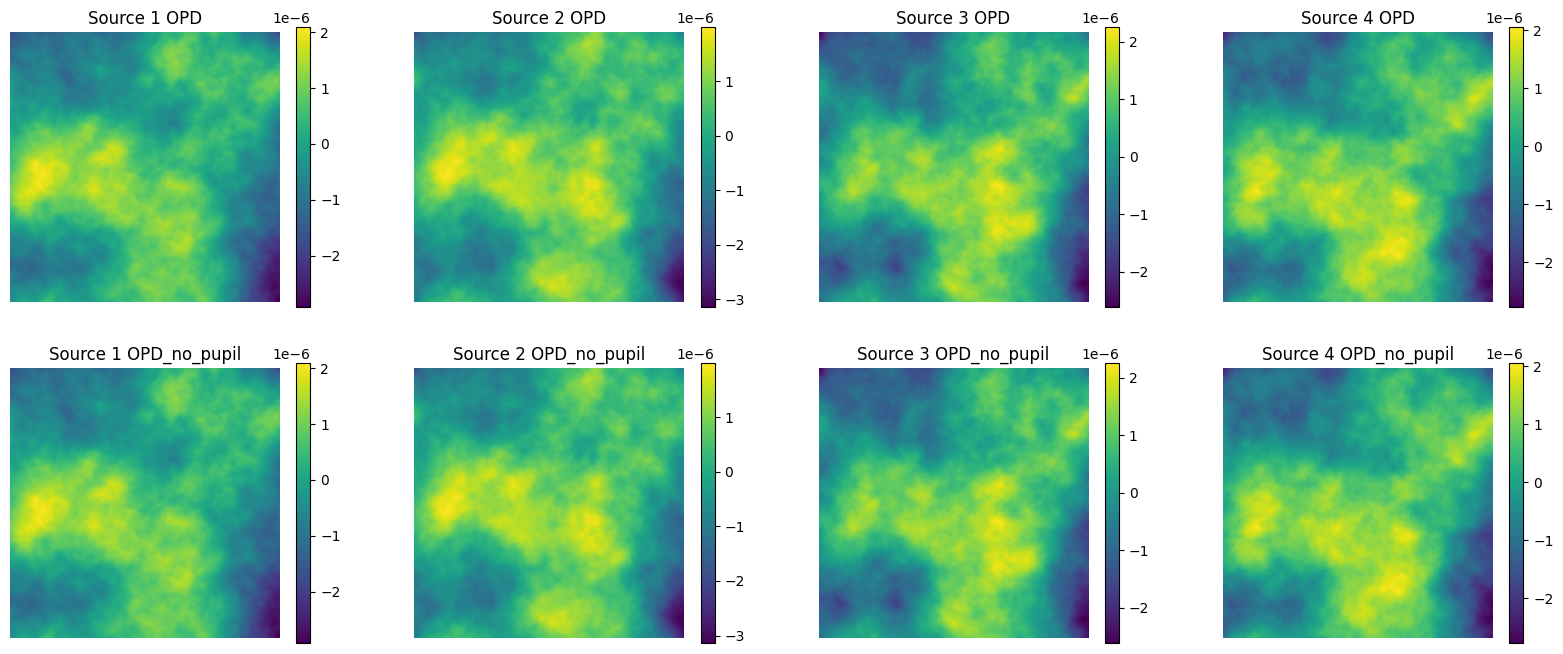

In [7]:
lgsAst**atm

lgsAst.print_optical_path()

fig, axes = plt.subplots(2, n_lgs, figsize=(20, 8))


for i in range(n_lgs):
    im = axes[0, i].imshow(lgsAst.OPD[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Source {i+1} OPD')
    fig.colorbar(im, ax=axes[0, i])

    im = axes[1, i].imshow(lgsAst.OPD_no_pupil[i])
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Source {i+1} OPD_no_pupil')
    fig.colorbar(im, ax=axes[1, i])


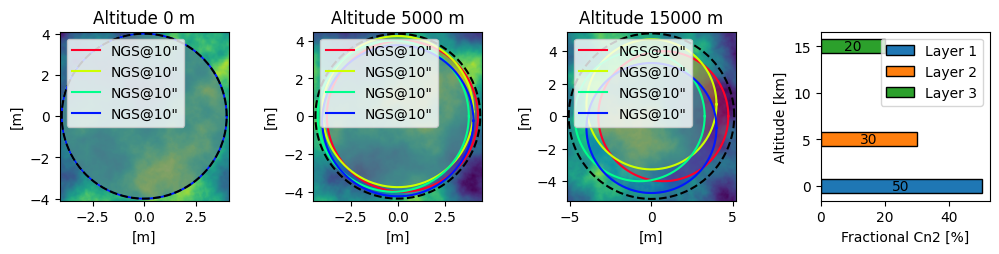

In [8]:
atm.display_atm_layers()

Once the light has propagated through the telescope, the OPD conforms to the pupil geometry.

NGS(Na) ~~> atmosphere ~~> telescope
NGS(Na) ~~> atmosphere ~~> telescope
NGS(Na) ~~> atmosphere ~~> telescope
NGS(Na) ~~> atmosphere ~~> telescope


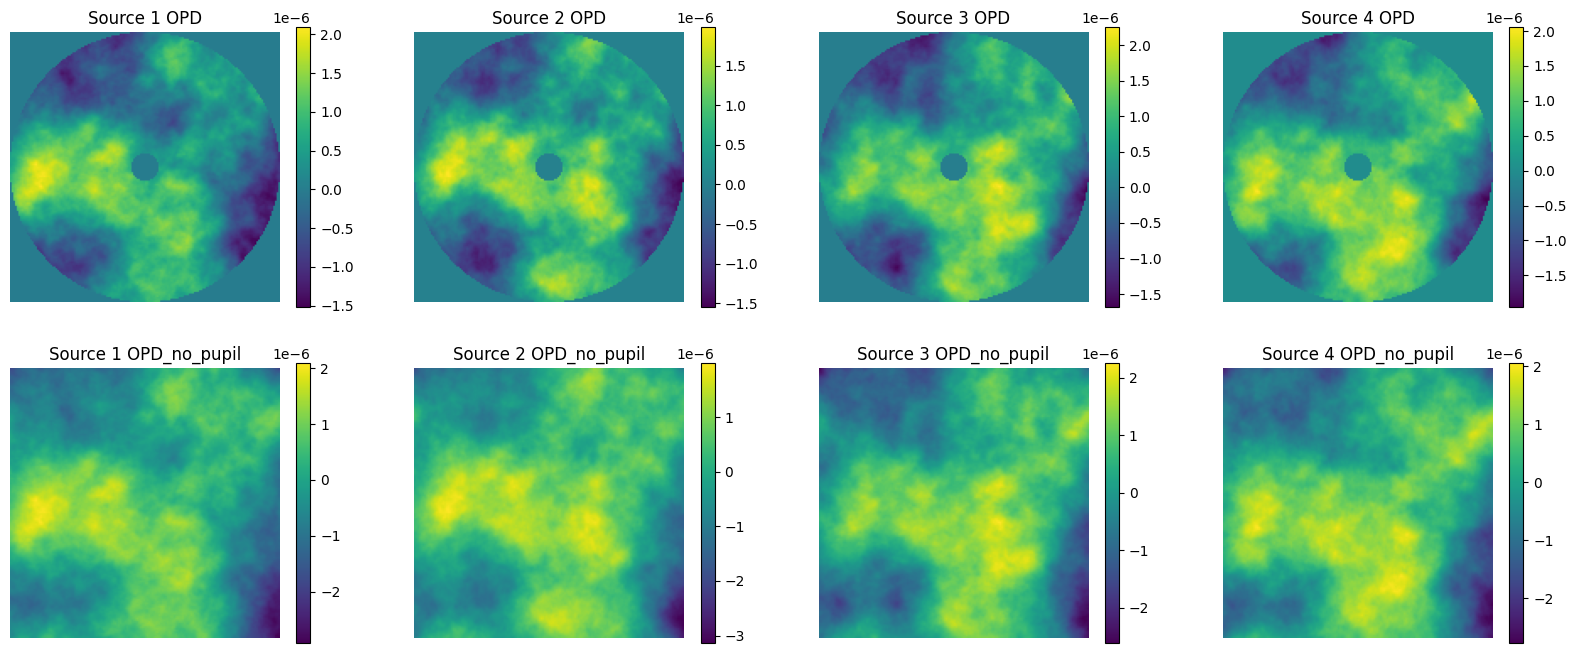

In [9]:
lgsAst*tel

lgsAst.print_optical_path()

fig, axes = plt.subplots(2, n_lgs, figsize=(20, 8))

for i in range(n_lgs):
    im = axes[0, i].imshow(lgsAst.OPD[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Source {i+1} OPD')
    fig.colorbar(im, ax=axes[0, i])

    im = axes[1, i].imshow(lgsAst.OPD_no_pupil[i])
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Source {i+1} OPD_no_pupil')
    fig.colorbar(im, ax=axes[1, i])


## ShackHartmann Object

No user-input pixel scale - using shannon_sampling input value:2 pixel(s) per spot FWHM
-------------Detector--------------
Sensor type              |   CCD   
Resolution [px]          |   160   
Gain                     |    1    
Quantum efficiency [%]   |   100   
Binning                  |   1x1   
Dark current [e-/px/s]   |  0.00   
Photon noise             |  False  
Bkg noise [e-]           |  False  
Readout noise [e-/px]    |   0.0   
-----------------------------------

Selecting valid subapertures based on flux considerations..
Acquiring reference slopes..
updating the flux of the SHWFS object
Done!
Recalibrating the slopes units
Acquiring reference slopes..
Done!
Done
OOPAO Warning: 
All Detector Noises are disables with the geometric WFS

------- Shack-Hartmann WFS --------
Subapertures [lenslets]  |   20    
Subaperture Pitch [m]    |  0.40   
Subaperture FoV [arcsec] |  1.21   
Pixel Scale [arcsec]     |  0.152  
Valid Subapertures       |   624   
Spot Sampling [pix]   

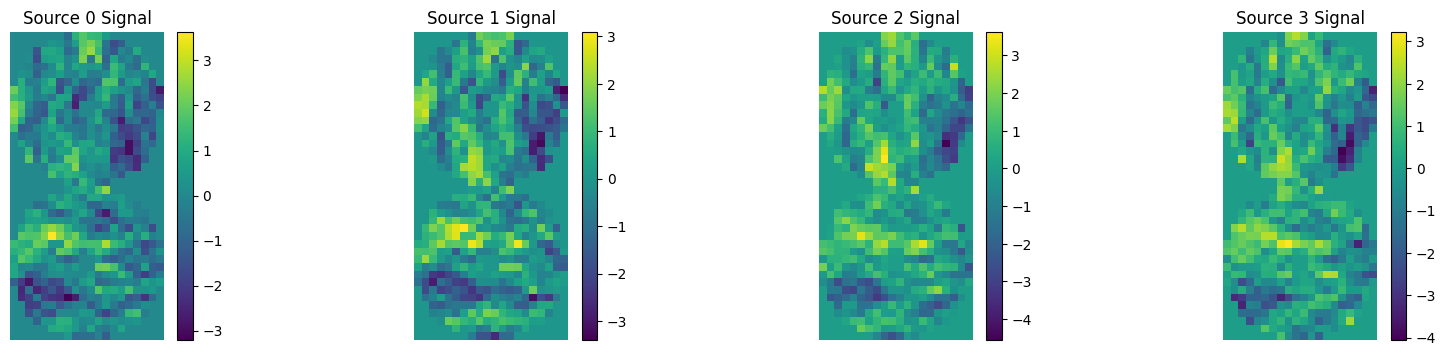

In [10]:
from OOPAO.ShackHartmann import ShackHartmann

is_geometric = True
if config_vars["wfs_type"] == "d":
    is_geometric = False


shwfs = ShackHartmann(telescope          = tel,
                      nSubap             = n_subaperture,
                      lightRatio         = 0.5,
                      is_geometric       = is_geometric,
                      shannon_sampling   = True,
                      threshold_cog      = 0.01)


shwfs.unfiltered_subap_mask = shwfs.valid_subapertures.copy()
shwfs.filtered_subap_mask = shwfs.valid_subapertures.copy()


if config_vars["loop_mode"] == 'closed':
    # If runnig a closed loop, create a geometric one to compute the interaction matrix
    shwfs_geom = ShackHartmann(telescope     = tel,
                        nSubap             = n_subaperture,
                        lightRatio         = 0.5,
                        is_geometric       = True,
                        shannon_sampling   = True,
                        threshold_cog      = 0.01)

    shwfs_geom.unfiltered_subap_mask = shwfs.valid_subapertures.copy()
    shwfs_geom.filtered_subap_mask = shwfs.valid_subapertures.copy()

lgsAst**atm*tel*shwfs

lgsAst.print_optical_path()

fig, axes = plt.subplots(1, n_lgs, figsize=(20, 4))

for i in range(n_lgs):
    im = axes[i].imshow(shwfs.signal_2D[i])
    axes[i].axis('off')
    axes[i].set_title(f'Source {i} Signal')
    fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)



## Deformable Mirror Object

In [11]:
from OOPAO.DeformableMirror import DeformableMirror


mechanical_coupling = config_vars['mechanicalCoupling']

# Get the valid actuators from the valid subapertures
valid_actuator_mask = shwfs.get_valid_actuators()
X, Y = tomoAO.tools.tomography_tools.meshgrid(config_vars['nActuator'], tel.D, 
                                              offset_x=0.0, offset_y=0.0, 
                                              stretch_x=1, stretch_y=1)

valid_actuator_coordinates = np.array([X[valid_actuator_mask], Y[valid_actuator_mask]]).T



dm = DeformableMirror(telescope    = tel,
                      coordinates  = valid_actuator_coordinates,
                      nSubap       = n_subaperture, # by default n_subaperture+1 actuators are considered (Fried Geometry)
                      mechCoupling = mechanical_coupling)


dm.unfiltered_act_mask = valid_actuator_mask.copy()


Coordinates loaded...
Generating a Deformable Mirror: 
Computing the 2D zonal modes...

-------- Deformable mirror --------
Controlled Actuators     |   356   
M4                       |  False  
Pitch [m]                |  0.40   
Mechnical coupling [%]   |   15    
== Misregistration ================
Rotation [°]             |  0.000  
Shift X [m]              |0.000e+00
Shift Y [m]              |0.000e+00
Anamorphosis angle [°]   |  0.000  
Tangential scaling [%]   |  0.000  
Radial scaling [%]       |  0.000  
-----------------------------------



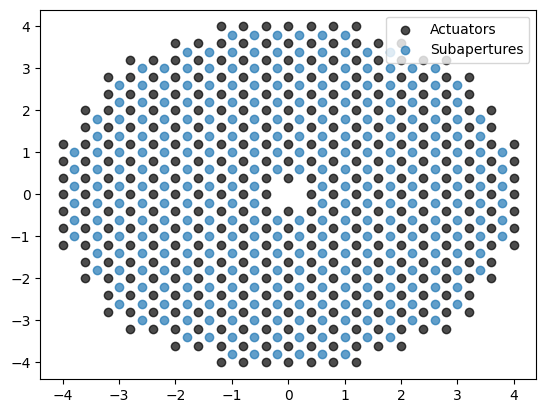

In [12]:
valid_subapertures = np.pad(shwfs.valid_subapertures,
            pad_width=(0,1),
            mode='constant',
            constant_values=0)

valid_subapertures_coordinates = np.array([X[valid_subapertures], 
                                           Y[valid_subapertures]]).T

plt.scatter(dm.coordinates[:, 0], dm.coordinates[:, 1], 
            label="Actuators", c="black", alpha=0.7)
plt.scatter(valid_subapertures_coordinates[:, 0]+0.2, valid_subapertures_coordinates[:, 1]+0.2,
             label="Subapertures", alpha=0.7)
plt.legend(loc="upper right")


NGS(Na) ~~> atmosphere ~~> telescope ~~> deformableMirror
NGS(Na) ~~> atmosphere ~~> telescope ~~> deformableMirror
NGS(Na) ~~> atmosphere ~~> telescope ~~> deformableMirror
NGS(Na) ~~> atmosphere ~~> telescope ~~> deformableMirror


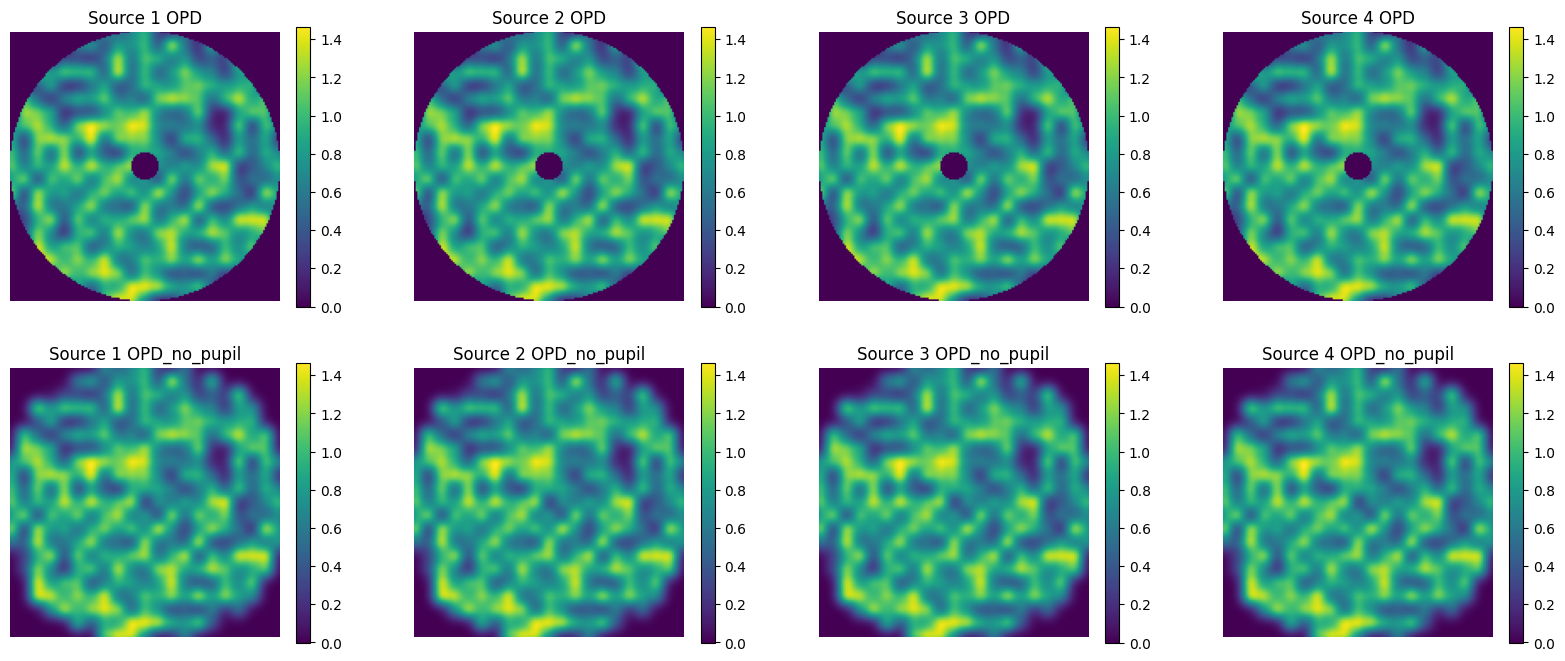

In [13]:
dm.coefs = np.random.rand(dm.nValidAct)

lgsAst**atm*tel*dm

lgsAst.print_optical_path()

fig, axes = plt.subplots(2, n_lgs, figsize=(20, 8))

for i in range(n_lgs):
    im = axes[0, i].imshow(lgsAst.OPD[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Source {i+1} OPD')
    fig.colorbar(im, ax=axes[0, i])

    im = axes[1, i].imshow(lgsAst.OPD_no_pupil[i])
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Source {i+1} OPD_no_pupil')
    fig.colorbar(im, ax=axes[1, i])

NGS(Na) ~~> atmosphere ~~> telescope ~~> deformableMirror
NGS(Na) ~~> atmosphere ~~> telescope ~~> deformableMirror
NGS(Na) ~~> atmosphere ~~> telescope ~~> deformableMirror
NGS(Na) ~~> atmosphere ~~> telescope ~~> deformableMirror


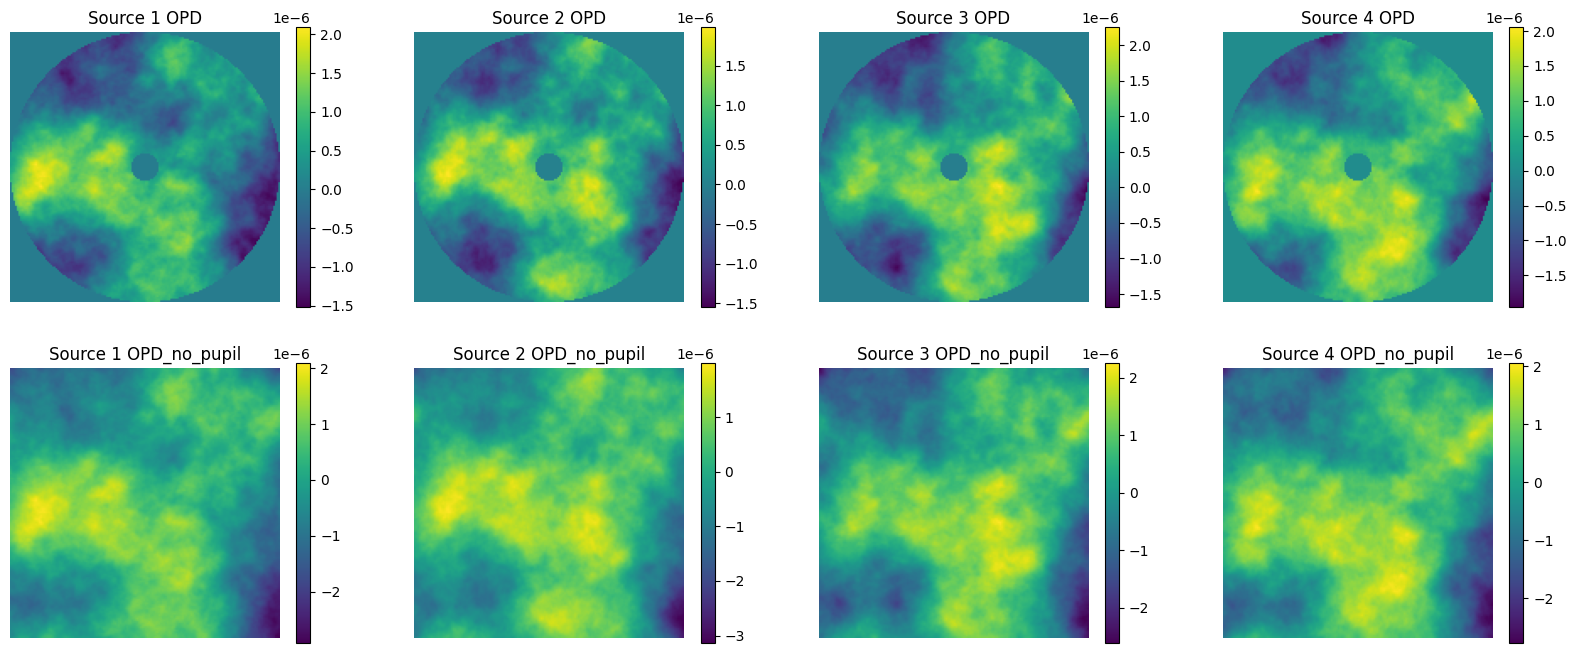

In [14]:
dm.coefs = 0

lgsAst**atm*tel*dm

lgsAst.print_optical_path()

fig, axes = plt.subplots(2, n_lgs, figsize=(20, 8))

for i in range(n_lgs):
    im = axes[0, i].imshow(lgsAst.OPD[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Source {i+1} OPD')
    fig.colorbar(im, ax=axes[0, i])

    im = axes[1, i].imshow(lgsAst.OPD_no_pupil[i])
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Source {i+1} OPD_no_pupil')
    fig.colorbar(im, ax=axes[1, i])

### AO System Object (tomoAO)
Used to build the tomographic reconstructor

In [15]:
aoSys = tomoAO.Simulation.AOSystem(config_vars, tel=tel, lgsAst=lgsAst, dm=dm, atm=atm, wfs=shwfs)



------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 5.9e-07 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  0.00   
Flux [photon/m²/s]       | 9.0e+09 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 2.2e-06 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  0.00   
Flux [photon/m²/s]       | 1.9e+09 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------

Coordinates loaded...
Generating a Deformable Mirror: 
Computing the 2D zonal modes...

-------- Deformable mirror --------
Controlled Actuators     |   356   
M4                       |  False  
Pitch [m]                |  0.40   
Mechnical coupling [%]   |   15    
== Misregistra

### Tomographic Reconstructor Object (tomoAO)


In [16]:
from tomoAO.Reconstruction.reconClassType import tomoReconstructor

rec = tomoReconstructor(aoSys=aoSys, alpha=10, os=2)

Updating the Atmosphere covariance matrices...
GPU not available, using CPU
Building Gamma
Took 0.11235570907592773 seconds to build Gamma
Building the covariance matrices
Took 9.493790626525879 seconds to build the covariance matrices
Building the reconstructor
Took 8.626380681991577 seconds to build the reconstructor


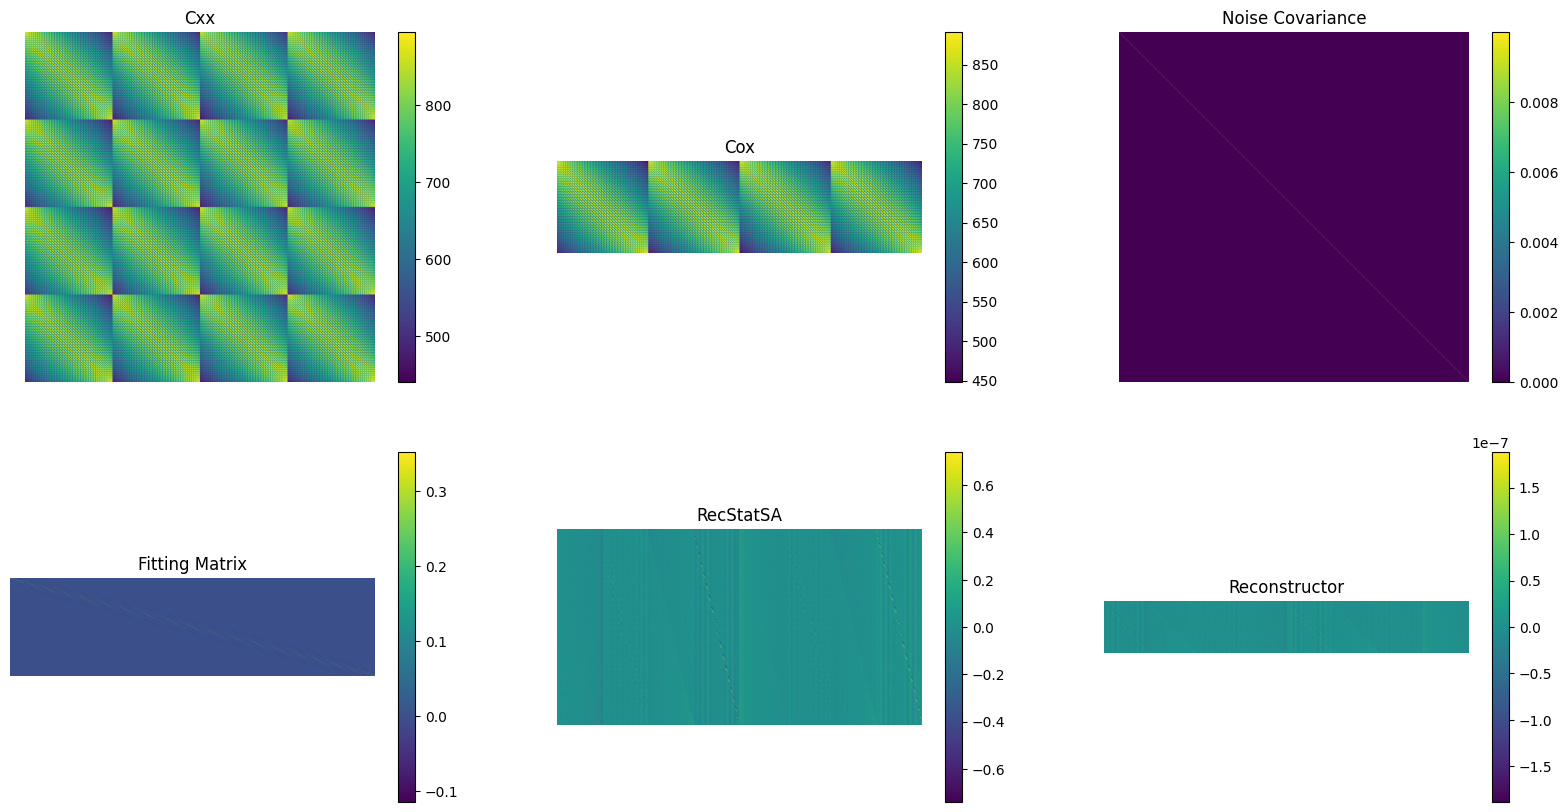

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

im = axes[0, 0].imshow(rec.Cxx)
axes[0, 0].axis('off')
axes[0, 0].set_title(f'Cxx')
fig.colorbar(im, ax=axes[0, 0])

im = axes[0, 1].imshow(rec.Cox[0])
axes[0, 1].axis('off')
axes[0, 1].set_title(f'Cox')
fig.colorbar(im, ax=axes[0, 1])

im = axes[0, 2].imshow(rec.noise_covariance)
axes[0, 2].axis('off')
axes[0, 2].set_title(f'Noise Covariance')
fig.colorbar(im, ax=axes[0, 2])


im = axes[1, 0].imshow(rec.fittingMatrix)
axes[1, 0].axis('off')
axes[1, 0].set_title(f'Fitting Matrix')
fig.colorbar(im, ax=axes[1, 0])

im = axes[1, 1].imshow(rec.RecStatSA[0])
axes[1, 1].axis('off')
axes[1, 1].set_title(f'RecStatSA')
fig.colorbar(im, ax=axes[1, 1])


im = axes[1, 2].imshow(rec.reconstructor)
axes[1, 2].axis('off')
axes[1, 2].set_title(f'Reconstructor')
fig.colorbar(im, ax=axes[1, 2])


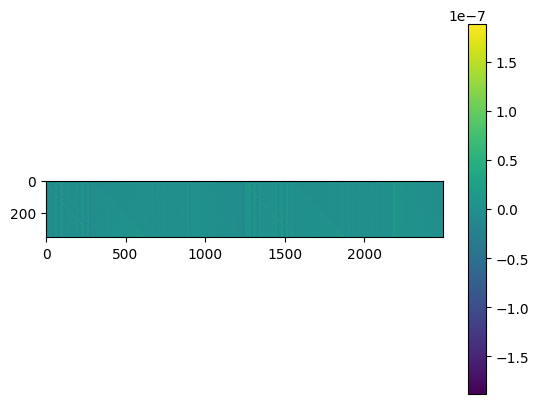

In [18]:
reconstructor = rec.reconstructor.copy()

plt.imshow(reconstructor)
plt.colorbar()

### Test the reconstructor

In [19]:
from OOPAO.calibration.compute_KL_modal_basis import compute_KL_basis
M2C_KL = compute_KL_basis(src=lgsAst.src[0],tel=tel,atm=atm,dm=dm)

TIME ELAPSED: 3 sec. COMPLETED: 100 %
NMAX =  355
RMS opd error = [[1.71395560e-08 2.05824385e-08 2.05824385e-08]]
RMS Positions = [[7.00053659e-08 6.66058857e-07 6.66058857e-07]]
MAX Positions = [[7.64935592e-07 1.48894032e-06 1.48894032e-06]]
KL WITH DOUBLE DIAGONALISATION: COVARIANCE ERROR =  2.042810365310288e-14


In [20]:
stop

NameError: name 'stop' is not defined

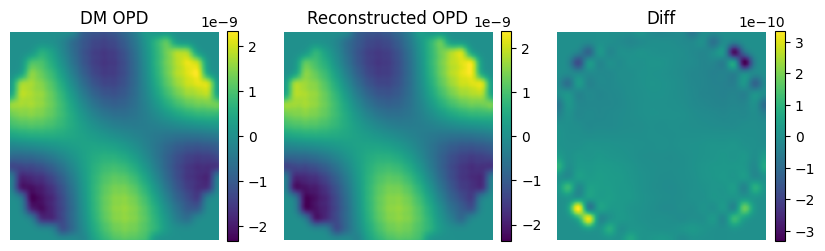

In [21]:
mode = 6

input_modes = 1e-9

dm.coefs = M2C_KL[:,mode] * input_modes

lgsAst**tel*dm*shwfs
shwfs.signal = np.hstack(shwfs.signal)


fig, axes = plt.subplots(1, 3, figsize=(10, 6))

dm_OPD = dm.OPD
im = axes[0].imshow(dm_OPD)
axes[0].axis('off')
axes[0].set_title(f'DM OPD')
fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)


rec_OPD = (dm.modes@reconstructor@shwfs.signal).reshape((tel.resolution, tel.resolution))#.T

im = axes[1].imshow(rec_OPD)
axes[1].axis('off')
axes[1].set_title(f'Reconstructed OPD')
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

im = axes[2].imshow((dm.OPD-rec_OPD))
axes[2].axis('off')
axes[2].set_title(f'Diff')
fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

### Loop

-------------Detector--------------
Sensor type              |   CCD   
Resolution [px]          |   640   
Gain                     |    1    
Quantum efficiency [%]   |   100   
Binning                  |   1x1   
Dark current [e-/px/s]   |  0.00   
Photon noise             |  False  
Bkg noise [e-]           |  False  
Readout noise [e-/px]    |   0.0   
-----------------------------------


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 1.7e-06 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  0.00   
Flux [photon/m²/s]       | 2.9e+09 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------

Updating the Atmosphere covariance matrices...


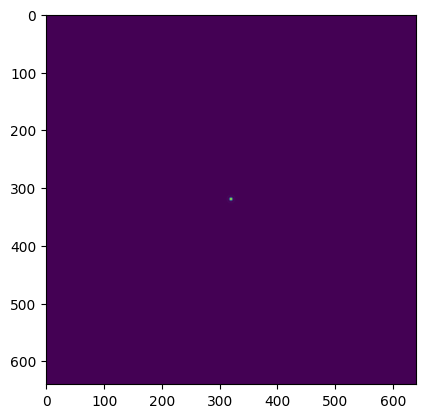

Running open loop with geometric sensor


In [22]:
from OOPAO.Detector import Detector
SciSrc_cam = Detector(tel.resolution*4)
SciSrc_cam.psf_sampling = 4
SciSrc_cam.integrationTime = tel.samplingTime*1


# Define a scientific source:
SciSrc = Source(optBand='H', magnitude=0)

dm.coefs = 0      # initialize DM commands

# initialize DM commands
SciSrc**atm*tel*dm*SciSrc_cam


nLoop = config_vars["nLoop"]

# allocate memory to save data
SR                      = np.zeros(nLoop)
total                   = np.zeros(nLoop)
residual                = np.zeros(nLoop)
wfsSignal               = np.arange(0,shwfs.nSignal*n_lgs)*0

# loop parameters
gainCL                  = config_vars["gainCL"]
# display                 = True

atm.r0=0.16
atm.generateNewPhaseScreen(10)
# Save reference frame 
SciSrc**tel*dm*SciSrc_cam
plt.imshow(SciSrc_cam.frame)
plt.show()
SciSrc_cam.reference_frame = SciSrc_cam.frame.copy()



from tqdm import tqdm

if config_vars["loop_mode"] == 'closed':
    calib_src = Source('Na', 0)

    calib_src**atm

    dm_eye = np.eye(dm.nValidAct)
    imat = np.zeros((shwfs_geom.nValidSubaperture*2, dm.nValidAct)) 
    for i_act in tqdm(range(dm.nValidAct)):
        dm.coefs = dm_eye[:, i_act]*calib_src.wavelength/2/np.pi
        calib_src**tel*dm*shwfs_geom
        imat[:, i_act] = shwfs_geom.signal

    imat = imat*2*np.pi/calib_src.wavelength    
    imat = np.vstack([imat]*n_lgs)

print(f"Running {config_vars['loop_mode']} loop with {'geometric' if config_vars['wfs_type'] == 'g' else 'diffractive'} sensor")


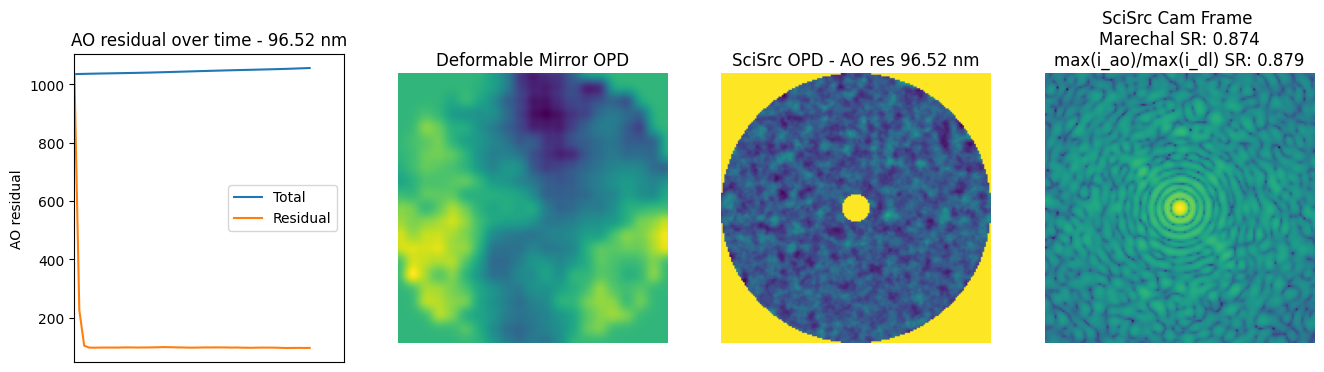

In [23]:
from IPython.display import display, clear_output

# lgsAst**atm*tel*dm*shwfs

if config_vars["display_figures"]:
    fig = plt.figure(figsize=(16, 4))  
    ax1 = fig.add_subplot(1, 4, 1)
    ax2 = fig.add_subplot(1, 4, 2)
    ax3 = fig.add_subplot(1, 4, 3)
    ax4 = fig.add_subplot(1, 4, 4)

for i in range(nLoop):

    atm.update()
    SciSrc**atm*tel

    total[i]=np.std(SciSrc.OPD[np.where(tel.pupil>0)])*1e9


    if config_vars["loop_mode"] == 'open':
        lgsAst**atm*tel*shwfs*dm

    elif config_vars["loop_mode"] == 'closed':
        lgsAst**atm*tel*dm*shwfs
    
    wfsSignal = np.hstack(shwfs.signal) 

    if config_vars["loop_mode"] == 'closed':
        wfsSignal = wfsSignal-imat@dm.coefs
    

    SciSrc**atm*tel*dm*SciSrc_cam


    dm.coefs = (1-gainCL)*dm.coefs - gainCL * (reconstructor@wfsSignal)


    SR[i]=np.exp(-np.var(SciSrc.phase[np.where(tel.pupil==1)]))
    residual[i] = np.sqrt(np.var(SciSrc.OPD[np.where(SciSrc.mask==1)])) * 1e9

    
    if config_vars["display_figures"]:
        ax1.cla()
        ax1.plot(total[:i], label="Total")
        ax1.plot(residual[:i], label="Residual")
        
        ax1.set_xlim(0, nLoop+5)
        ax1.set_ylabel("AO residual")
        ax1.set_title(f"AO residual over time - {round(residual[i], 2)} nm")
        ax1.legend()
        ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

        ax2.cla()
        ax2.imshow(dm.OPD)
        ax2.axis('off')
        ax2.set_title(f'Deformable Mirror OPD')

        ax3.cla()
        ax3.imshow(SciSrc.OPD)
        ax3.axis('off')
        ax3.set_title(f"SciSrc OPD - AO res {round(residual[i], 2)} nm")
        
        tel.pupilReflectivity = tel.pupil.astype(float)


        zeroPaddingFactor = 6
        tel.computePSF(zeroPaddingFactor=zeroPaddingFactor, detector=SciSrc_cam)

        size_pixel_arcsec = 206265*(tel.src.wavelength/tel.D)/zeroPaddingFactor
        N                 = 250
        normalized_PSF    = tel.PSF[N:-N,N:-N]
        fov               = normalized_PSF.shape[0]*size_pixel_arcsec

        ax4.cla()
        ax4.imshow(np.log10(normalized_PSF),extent=[-fov/2,fov/2,-fov/2,fov/2])
        ax4.axis('off')
        ax4.set_title(f"SciSrc Cam Frame \nMarechal SR: {round(SR[i], 3)}\nmax(i_ao)/max(i_dl) SR: {round(np.max(SciSrc_cam.frame)/np.max(SciSrc_cam.reference_frame), 3)}")


        display(fig)
        clear_output(wait = True)
    else:
        print('Loop'+str(i)+'/'+str(nLoop)+' AO residual: '+str(residual[i])+' nm')

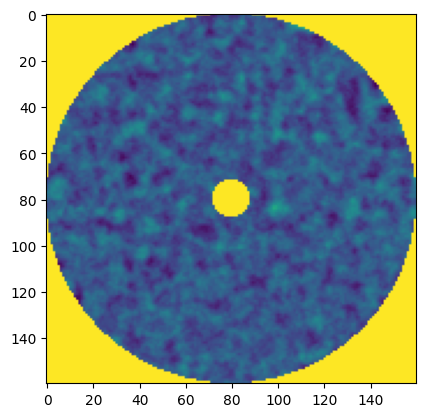

In [24]:
plt.imshow(SciSrc.OPD)

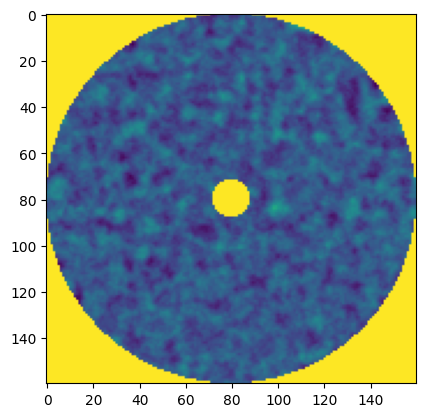

In [25]:
plt.imshow(SciSrc.OPD*SciSrc.mask)


## Results

In [26]:
print(f"AO res {round(np.mean(residual), 2)} nm")
print(f"Marechal SR: {round(np.mean(SR)*100, 2)}%")
print(f"max(i_ao)/max(i_dl) SR: {round(np.max(SciSrc_cam.frame)/np.max(SciSrc_cam.reference_frame)*100, 2)}%")


AO res 118.99 nm
Marechal SR: 84.61%
max(i_ao)/max(i_dl) SR: 87.93%


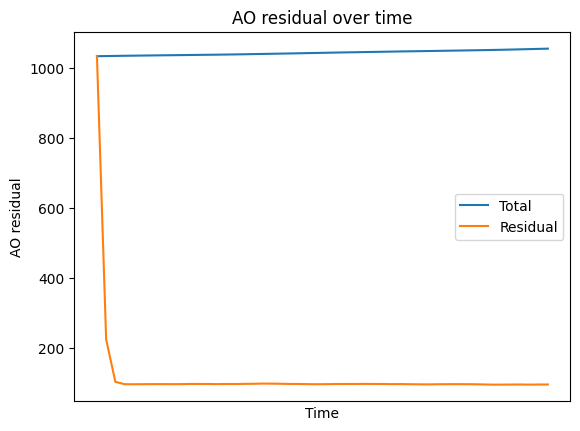

In [27]:
plt.figure()
plt.plot(total, label="Total")
plt.plot(residual, label="Residual")
plt.xlabel("Time")
plt.ylabel("AO residual")
plt.title("AO residual over time")
plt.legend()
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)


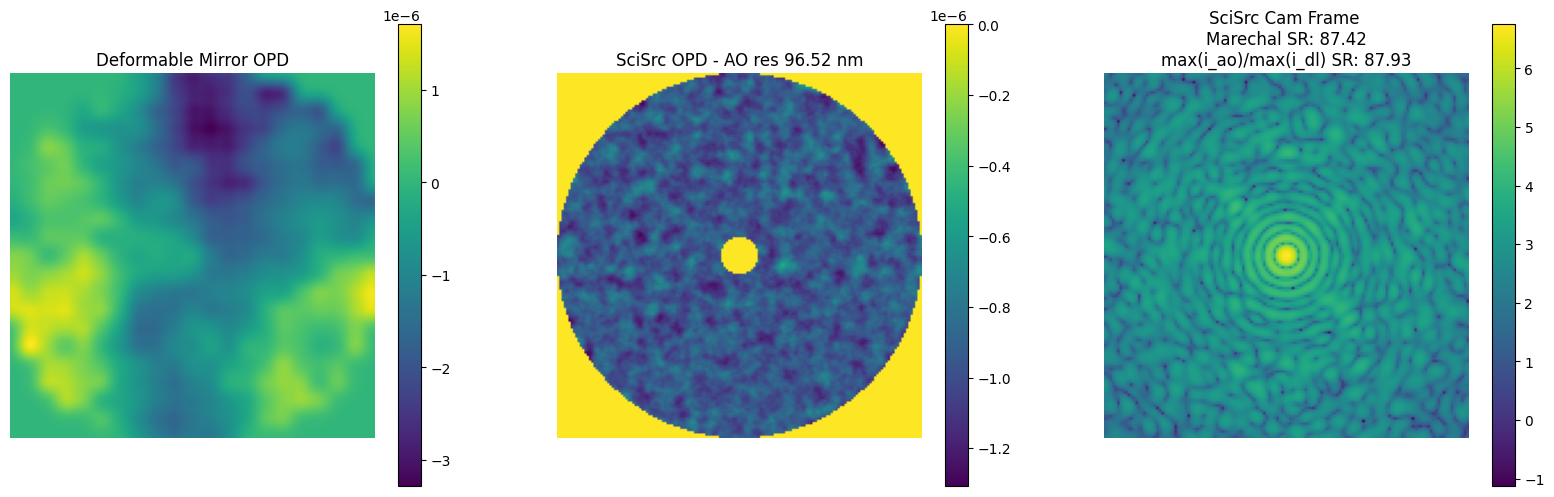

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

im = axes[0].imshow(dm.OPD)
axes[0].axis('off')
axes[0].set_title(f'Deformable Mirror OPD')
fig.colorbar(im, ax=axes[0])

im = axes[1].imshow(SciSrc.OPD)
axes[1].axis('off')
axes[1].set_title(f"SciSrc OPD - AO res {round(residual[-1], 2)} nm")
fig.colorbar(im, ax=axes[1])


# set back the reflectivity 1
tel.pupilReflectivity = tel.pupil.astype(float)

SciSrc**atm*tel*dm 

# compute PSF method
zeroPaddingFactor = 6
tel.computePSF(zeroPaddingFactor=zeroPaddingFactor, detector=SciSrc_cam)

# get current pixel scale
size_pixel_arcsec = 206265*(tel.src.wavelength/tel.D)/zeroPaddingFactor
N                 = 250
normalized_PSF    = tel.PSF[N:-N,N:-N]# crop to zoom on the center
fov               = normalized_PSF.shape[0]*size_pixel_arcsec # get the corresponding fov


im = axes[2].imshow(np.log10(normalized_PSF),extent=[-fov/2,fov/2,-fov/2,fov/2])
axes[2].axis('off')
axes[2].set_title(f"SciSrc Cam Frame \nMarechal SR: {round(SR[-1]*100, 2)}\nmax(i_ao)/max(i_dl) SR: {round(np.max(SciSrc_cam.frame)/np.max(SciSrc_cam.reference_frame)*100, 2)}")
fig.colorbar(im, ax=axes[2])

